In [ ]:
!pip install torch torchvision torchaudio

In [15]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")


import os
import torch
import utils
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import torchvision
from torchvision.transforms import v2 as T
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

from engine import train_one_epoch, evaluate



class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        img = tv_tensors.Image(img)
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target
    def __len__(self):
        return len(self.imgs)
def get_model(num_classes):
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)

    backbone.out_channels = 256

    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),) * 5,
        aspect_ratios=((0.5, 1.0, 2.0),) * 5
    )

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )

    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler
    )

    return model

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

model = get_model(num_classes=2)

dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0, collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0, collate_fn=utils.collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)

model.eval()
x = [torch.rand(3, 300, 400, device=device), torch.rand(3, 500, 400, device=device)]
predictions = model(x)
print(predictions)

Epoch: [0]  [ 0/60]  eta: 0:00:43  lr: 0.000090  loss: 1.7785 (1.7785)  loss_classifier: 0.7340 (0.7340)  loss_box_reg: 0.0978 (0.0978)  loss_objectness: 0.6875 (0.6875)  loss_rpn_box_reg: 0.2592 (0.2592)  time: 0.7286  data: 0.0406  max mem: 10916
Epoch: [0]  [10/60]  eta: 0:00:37  lr: 0.000936  loss: 1.6990 (1.7065)  loss_classifier: 0.7036 (0.6747)  loss_box_reg: 0.1421 (0.1467)  loss_objectness: 0.6886 (0.6887)  loss_rpn_box_reg: 0.1866 (0.1964)  time: 0.7589  data: 0.0297  max mem: 10916
Epoch: [0]  [20/60]  eta: 0:00:31  lr: 0.001783  loss: 1.5868 (1.6539)  loss_classifier: 0.4948 (0.5344)  loss_box_reg: 0.1729 (0.2642)  loss_objectness: 0.6776 (0.6648)  loss_rpn_box_reg: 0.1866 (0.1905)  time: 0.7978  data: 0.0300  max mem: 10916
Epoch: [0]  [30/60]  eta: 0:00:23  lr: 0.002629  loss: 1.4722 (1.5466)  loss_classifier: 0.2846 (0.4409)  loss_box_reg: 0.3627 (0.3037)  loss_objectness: 0.5715 (0.6119)  loss_rpn_box_reg: 0.1943 (0.1901)  time: 0.7992  data: 0.0321  max mem: 10916
Epoc

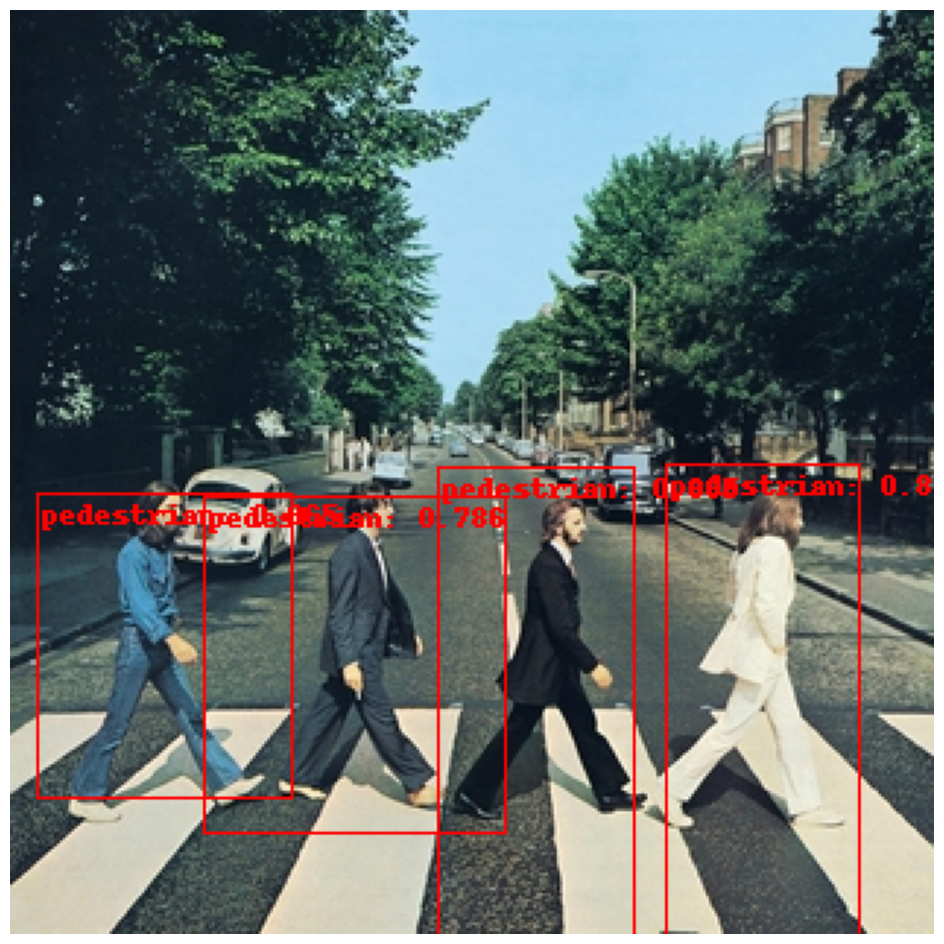

In [22]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import nms

image = read_image("Beatles.jpg")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

confidence_threshold = 0.5
keep = pred['scores'] > confidence_threshold
boxes = pred['boxes'][keep]
scores = pred['scores'][keep]
labels = pred['labels'][keep]

keep = nms(boxes, scores, iou_threshold=0.3)
final_boxes = boxes[keep]
final_scores = scores[keep]
final_labels = labels[keep]

pred_labels = [f"pedestrian: {score:.3f}" for score in final_scores]

output_image = draw_bounding_boxes(image[:3, ...], final_boxes.long(), pred_labels, colors="red")

output_image = (255.0 * (output_image - output_image.min()) / (output_image.max() - output_image.min())).to(torch.uint8)
plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.axis('off')  # Hide the axes
plt.show()